# SHAP-IQ with scikit-learn

In this example, we use the popular California housing dataset for regression available at https://www.kaggle.com/datasets/camnugent/california-housing-prices.

### import packages

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import shapiq

shapiq.__version__

'0.0.8'

### load data

In [9]:
X, y = shapiq.load_california_housing()
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.25, random_state=42
)
n_features = X_train.shape[1]

### train a model

In [10]:
model = RandomForestRegressor(
    n_estimators=500, max_depth=n_features, max_features=2 / 3, max_samples=2 / 3, random_state=42
)
model.fit(X_train, y_train)
print("Train R2: {:.4f}".format(model.score(X_train, y_train)))
print("Test  R2: {:.4f}".format(model.score(X_test, y_test)))

Train R2: 0.7990
Test  R2: 0.7462


### model-agnostic explainer

We use `shapiq.TabularExplainer` to explain any machine learning model for tabular data. 

It has the following basic parameters:
- `model`: The model to be explained as a callable function expecting data points as input and returning 1-dimensional predictions.
- `data`: A background dataset to be used for imputation.

In [11]:
explainer_tabular = shapiq.TabularExplainer(model=model, data=X_train, index="SII")

Next, select an instance to be explained.

In [12]:
x = X_test[24]

Call an `explain()` interface setting the `budget`, i.e. the maximum number of model evaluations (coallitions).

In [13]:
interaction_values = explainer_tabular.explain(x, budget=2**n_features)
interaction_values

InteractionValues(
    index=SII, max_order=2, min_order=0, estimated=False, estimation_budget=256,
    n_players=8, baseline_value=1.4750918130350397
)

An output is stored in the `shapiq.InteractionValues` object. Its main attribute is `dict_values` storing Shapley interaction values as a dictionary.

In [14]:
interaction_values.dict_values

{(): 0.0,
 (0,): 0.16025696756186117,
 (1,): -0.017830437595603918,
 (2,): 0.04877073527923153,
 (3,): -0.00220789814661574,
 (4,): -1.0408340855860843e-17,
 (5,): 0.06393546999805577,
 (6,): 0.2353610041151418,
 (7,): -0.20099446986144315,
 (0, 1): -0.018638451089283338,
 (0, 2): -0.07637470658649753,
 (0, 3): -0.00142826848433434,
 (0, 4): 8.673617379884035e-18,
 (0, 5): 0.005380595812907053,
 (0, 6): -0.0821711556712731,
 (0, 7): -0.010495701565712784,
 (1, 2): -0.0006269474736254714,
 (1, 3): 0.0003718443409339543,
 (1, 4): -2.0816681711721685e-17,
 (1, 5): 0.003559974557809731,
 (1, 6): 0.00944262866737193,
 (1, 7): 0.011600099140373216,
 (2, 3): -6.257050574237817e-05,
 (2, 4): -2.6020852139652106e-17,
 (2, 5): 0.010209585003575779,
 (2, 6): -0.037546776073881696,
 (2, 7): -0.022687364980706923,
 (3, 4): -1.0408340855860843e-17,
 (3, 5): -0.0004975816888609886,
 (3, 6): -0.002312641207491635,
 (3, 7): 0.00016625348317340655,
 (4, 5): -3.122502256758253e-17,
 (4, 6): 1.82145964977

One can retrieve only 2-order values with `get_n_order(2)` (object) and `get_n_order_values(2)` (values themselves).

In [15]:
interaction_values.get_n_order(2).dict_values

{(0, 1): -0.018638451089283338,
 (0, 2): -0.07637470658649753,
 (0, 3): -0.00142826848433434,
 (0, 4): 8.673617379884035e-18,
 (0, 5): 0.005380595812907053,
 (0, 6): -0.0821711556712731,
 (0, 7): -0.010495701565712784,
 (1, 2): -0.0006269474736254714,
 (1, 3): 0.0003718443409339543,
 (1, 4): -2.0816681711721685e-17,
 (1, 5): 0.003559974557809731,
 (1, 6): 0.00944262866737193,
 (1, 7): 0.011600099140373216,
 (2, 3): -6.257050574237817e-05,
 (2, 4): -2.6020852139652106e-17,
 (2, 5): 0.010209585003575779,
 (2, 6): -0.037546776073881696,
 (2, 7): -0.022687364980706923,
 (3, 4): -1.0408340855860843e-17,
 (3, 5): -0.0004975816888609886,
 (3, 6): -0.002312641207491635,
 (3, 7): 0.00016625348317340655,
 (4, 5): -3.122502256758253e-17,
 (4, 6): 1.8214596497756474e-17,
 (4, 7): -1.214306433183765e-17,
 (5, 6): 0.008878047093077372,
 (5, 7): -0.009948213527318926,
 (6, 7): -0.049391723939249677}

In [16]:
interaction_values.get_n_order_values(2)

array([[ 1.60256968e-01, -1.86384511e-02, -7.63747066e-02,
        -1.42826848e-03,  8.67361738e-18,  5.38059581e-03,
        -8.21711557e-02, -1.04957016e-02],
       [-1.86384511e-02, -1.78304376e-02, -6.26947474e-04,
         3.71844341e-04, -2.08166817e-17,  3.55997456e-03,
         9.44262867e-03,  1.16000991e-02],
       [-7.63747066e-02, -6.26947474e-04,  4.87707353e-02,
        -6.25705057e-05, -2.60208521e-17,  1.02095850e-02,
        -3.75467761e-02, -2.26873650e-02],
       [-1.42826848e-03,  3.71844341e-04, -6.25705057e-05,
        -2.20789815e-03, -1.04083409e-17, -4.97581689e-04,
        -2.31264121e-03,  1.66253483e-04],
       [ 8.67361738e-18, -2.08166817e-17, -2.60208521e-17,
        -1.04083409e-17, -1.04083409e-17, -3.12250226e-17,
         1.82145965e-17, -1.21430643e-17],
       [ 5.38059581e-03,  3.55997456e-03,  1.02095850e-02,
        -4.97581689e-04, -3.12250226e-17,  6.39354700e-02,
         8.87804709e-03, -9.94821353e-03],
       [-8.21711557e-02,  9.442628

### visualization of Shapley interactions

`shapiq` includes the following plotting functions:
- `network_plot()`
- `stacked_bar_plot()`
- `si_graph_plot()`

For details of their parameters, refer to the [API reference](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html).

(<Figure size 600x600 with 1 Axes>, <Axes: >)

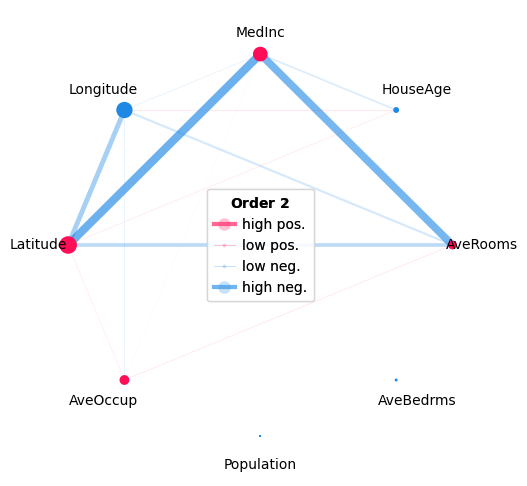

In [17]:
shapiq.network_plot(
    first_order_values=interaction_values.get_n_order_values(1),
    second_order_values=interaction_values.get_n_order_values(2),
    feature_names=X.columns,
)

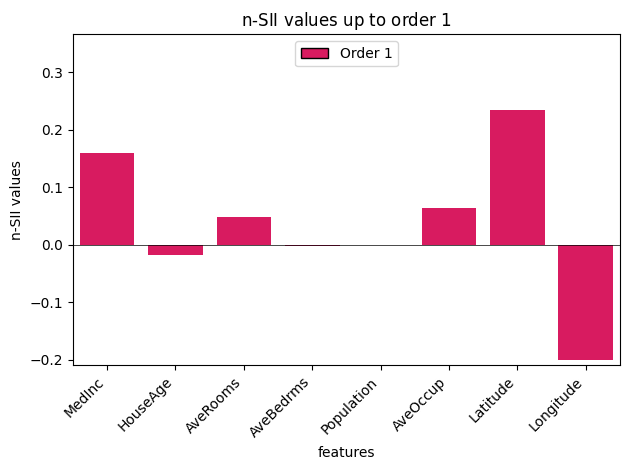

In [18]:
_ = shapiq.stacked_bar_plot(
    n_shapley_values_pos={
        1: np.array([0 if x < 0 else x for x in interaction_values.get_n_order_values(1)])
    },
    n_shapley_values_neg={
        1: np.array([0 if x > 0 else x for x in interaction_values.get_n_order_values(1)])
    },
    feature_names=X.columns,
)

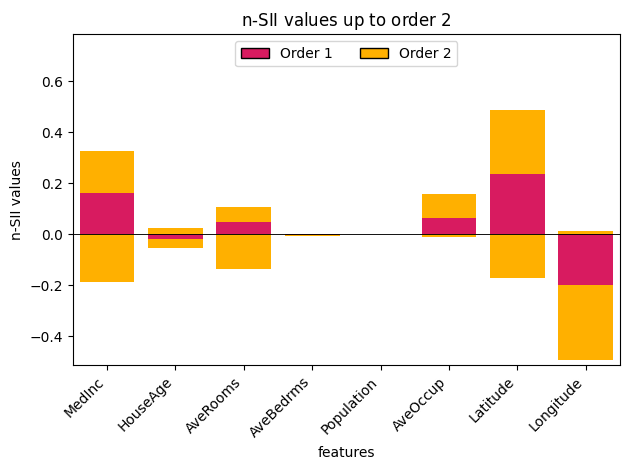

In [19]:
_ = shapiq.stacked_bar_plot(
    n_shapley_values_pos={
        1: np.array([0 if x < 0 else x for x in interaction_values.get_n_order_values(1)]),
        2: interaction_values.get_n_order_values(2).clip(min=0).sum(axis=0),
    },
    n_shapley_values_neg={
        1: np.array([0 if x > 0 else x for x in interaction_values.get_n_order_values(1)]),
        2: interaction_values.get_n_order_values(2).clip(max=0).sum(axis=0),
    },
    feature_names=X.columns,
    n_sii_max_order=2,
)